In [1]:
using PyPlot
using PyCall
using Printf
@pyimport matplotlib.animation as anim
@pyimport matplotlib.patches as patches

In [2]:
using Base64
function showanim(filename)
    base64_video = base64encode(open(filename))
    display("text/html", """<video controls src="data:video/x-m4v;base64,$base64_video">""")
end

showanim (generic function with 1 method)

In [34]:
mutable struct World
    objects
    debug
    time_span
    time_interval
    ani
end

World() = World([], false, 10, 1, nothing)
World(debug) = World([], debug, 10, 1, nothing)
World(time_span, time_interval) = World([], false, time_span, time_interval, nothing)

function append(self::World, obj)
    push!(self.objects, obj)
end

function init_draw(self::World, ax)
    ax.set_aspect("equal")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel("X", fontsize=20)
    ax.set_ylabel("Y", fontsize=20)
end

function draw(self::World)
    fig, ax = subplots()
    init_draw(self, ax)    
    elems = []

    if self.debug
        for i = 1:1000
            one_step(self, i, elems, ax)
        end
    else
        self.ani = anim.FuncAnimation(fig, one_step, fargs=(self, elems, ax), 
            frames = Int(self.time_span/self.time_interval)+1, interval = Int(self.time_interval*1000))
        self.ani[:save]("test.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
    end 
    
end

function one_step(i,self::World, elems, ax)
    plt.cla()
    init_draw(self, ax)
    while length(elems) > 0
        pop!(elems)
    end
    vcat(elems, ax.text(-4.4, 4.5, string("t = ", @sprintf("%.2f[s]", self.time_interval * i) ), fontsize=10))
    for obj in self.objects
        draw(obj, ax, elems)
        if applicable(one_step, obj, 1.0)
            one_step(obj, 1.0)
        end
    end
end

one_step (generic function with 2 methods)

In [35]:
mutable struct Agent
    nu
    omega
end
function decision(self::Agent, observation=nothing)
    return self.nu, self.omega
end

decision (generic function with 2 methods)

In [36]:
mutable struct IdealRobot
    pose
    r
    color
    agent
    poses
end

IdealRobot(pose) = IdealRobot(pose, 0.2, "black", nothing, [pose])
IdealRobot(pose, color) = IdealRobot(pose, 0.2, color, nothing, [])
IdealRobot(pose, agent) = IdealRobot(pose, 0.2, "black", agent, [pose])
IdealRobot(pose, agent, color) = IdealRobot(pose, 0.2, color, agent, [pose])

function draw(self::IdealRobot, ax, elems)
    x,y,theta = self.pose
    xn = x + self.r * cos(theta)
    yn = y + self.r * sin(theta)
    elems = vcat(elems, ax.plot([x, xn], [y,yn], color = self.color))
    c = patches.Circle(xy=(x,y), radius = self.r, fill = false, color = self.color)
    elems = vcat(elems, [ax.add_patch(c)])
    
    push!(self.poses, self.pose)
    elems = vcat(elems, ax.plot([e[1] for e in self.poses], [e[2] for e in self.poses], linewidth=0.5, color="black"))
end

function state_transition(self::IdealRobot, nu, omega, time)
    t0 = self.pose[3]
    if abs(omega) < 1e-10
        return self.pose + [nu*cos(t0), nu*sin(t0), omega].*time
    else
        return self.pose + [nu/omega*(sin(t0+omega*time)-sin(t0)),
                                  nu/omega*(-cos(t0+omega*time)+cos(t0)),
                                 omega*time]
    end
end

function one_step(self::IdealRobot, time_interval)
    if isnothing(self.agent)
        return
    end
    nu, omega = decision(self.agent)
    self.pose = state_transition(self, nu, omega, time_interval)
end

one_step (generic function with 2 methods)

In [37]:
mutable struct Landmark
    pos
    id
end

Landmark(pos) = Landmark(pos, nothing)

function draw(self::Landmark, ax, elems)
    c = ax.scatter(self.pos[1], self.pos[2], s=100, marker="*", label="landmarks", color="orange")
    elems = vcat(elems, c)
    elems = vcat(elems, ax.text( self.pos[1], self.pos[2] , string("id:", string(self.id)), fontsize=10))
end

draw (generic function with 4 methods)

In [38]:
mutable struct Map
    landmarks
end

Map() = Map([])

function append_landmark(self::Map, landmark)
    landmark.id = length(self.landmarks)
    push!(self.landmarks, landmark)
end

function draw(self::Map, ax, elems)
    for Im in self.landmarks
        draw(Im, ax, elems)
    end
end

draw (generic function with 4 methods)

In [53]:
mutable struct IdealCamera
    map::Map
end

function data(self::IdealCamera, cam_pose)
    observed = []
    for lm in self.map.landmarks
        p = observation_function(self, cam_pose, lm.pos)
        push!(observed, (p, lm.id))
    end
    return observed
end

function observation_function(self::IdealCamera, cam_pose, obj_pos)
    diff = obj_pos - cam_pose[1:2]
    phi = atan(diff[2], diff[1]) - cam_pose[3]
    while phi > pi
        phi -= 2*pi
    end
    
    while phi < -pi
        phi += 2*pi
    end
    return [hypot(diff[1], diff[2]), phi]
end

observation_function (generic function with 1 method)

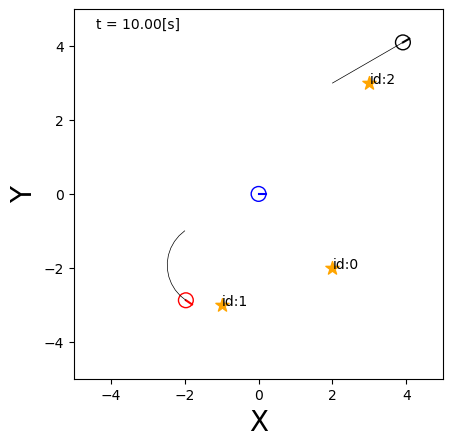

In [54]:
world = World(10, 1.0)
m = Map()
append_landmark(m, Landmark([2,-2]))
append_landmark(m, Landmark([-1,-3]))
append_landmark(m, Landmark([3,3]))
append(world, m)

straight = Agent(0.2, 0.0)
circling = Agent(0.2, 10.0/180*pi)
robot1 = IdealRobot([2, 3, pi/6], straight)
robot2 = IdealRobot([-2, -1, pi/5*6], circling, "red")
robot3 = IdealRobot([0,0,0], nothing, "blue")
append(world, robot1)
append(world, robot2)
append(world, robot3)
draw(world)

In [55]:
showanim("test.mp4")

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAALhptZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAFCFliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiASefdwlV7OOckzXd26jK6wIErr1WQUBXEvp/DSgNQ97tXAs3/wekXyhX1Mb3ZVyfb/nuH7YDUTAzDzDUPcJ9aGJDYprkjIs4WNPnmhxrM3XvnMTlFUoqbrQLvpNzo8719ZhI5+0JZaQYm2kUPpjTShXKw7xANuR5lXGYzlr5cI6Ho17qONWYMXE42iHgk8lbYLmkoPjHUk2Oy2lQv27aY/fVfrVFt/VTdo1sv9rKj/xyPGErip3Xb/vVsxHzOfglv+DWCgJihMuLKY4P4M4YYC7KnyHUObr9v+hCqCuPX7tw73SW3wY4C90D1WEjAU7+cX4vPjYbrTlxck/+jMG8V01u4NWmSrIcCUXOuIc/znVJ/Kigeb2s6GLZRFEjGSX2U/5rzp8diJrEu4EXJ/DkNrkdiYPvvTrKN+4tE1J4RjxIdQ0M0tjiPEGY/Tap5/KcmcBVHO5qzuO/7gObO3O8iYnComza9XHUY5nM8qTm6ndGruae8erB/etb0dJNLq8euDhX8x45T79bREfWJMAbMeYOVSHK6x61szIia8EpulzB5sJy3e6n2RZBo5qzhBHe12wOv7l73bxicciy6ycZZMnDVCnZhBQkUw6sewd9SU3crHsN5ubA3hKiT36C359reX8ltlaONYG//S/m7YG9HD9ReKH5K0mHiGopNT988Z5pMog+jeUiTn09vKWZgaLe60fUS9E/FuIWb3KR3CMIk7CJAlwzm8ijcV7mC0IX0AX88v16+1zeQTCb/so/E5ohU5/sW8/ph0XmuQRixP7IBkLhDFhHCrP0gcXobgApGOMqhiIx+5wFdkgRfd8pmPOiTyVUqCQAAffxiQYI6x3QMFOAX1WmUt8ItRgYblr8C2QxtNuOvD4OJqqqk1BrcKLlCFV13JWaXbjZGYkYjfbOl7HkO9+jig4gPLfC3uV6oN+nz2yMc+wtyThtW4wLDwaC2TO8pq86SjPwW2TxLP/O/dR8LDA9btI9vb7sk0wArM0PaSiNfA7GIIuqleaLw55QX1mI1ybTE8wmZBXQzNRccDnjG9ihWyzvcUtBWoRTz63pfFm3WCr/tw+JHROUJ8kFKQlj4mTflAKciFr36KzpZAAi4o+zZM6HOuoax+0k5uQIV1tvkgMswBQQz/ls3tl6sjjL9F2rY7H7rFy+bs68OvtVEV/RHYBylmifMFS2spKpfcBvPC5UHXuwzPl+E7XZh+4yMHQKwEaUcpLtc4THUsudpSXPhfjIcbgp9/mhphHH3WHYYttG1yCrr9wwpzgdUl3PoalIa9G6mso16jCp+KL3FQoWsoc0Whl7L7bzt7TC+6f4WGoe4vWUq3vP92LBJMKSPO4/tPuKk9fZpk3PnNaPUSVIz9pKiu5cppgEX9w6zrfc50Jbhjn2Gji7CTH+UdzGtYyhAbB41UEW0pedXC9sehnYZV3ZmUIyPy+hzksSP0ysope05VFA6Jfaxsp42JqPyMVOsq++qLrd7qtBuxLl4ZgnVixBAaCJ/xi0/kGTSP8ZUmzUrtwRnK88hgvxUnigCcM5NUktWJr1ijzIC3Dtx/7o09/TOr08Ykq5zf0S3F+bC8l3uO40yavV7Tv9sX2JJXwcHW22q1M6qPk6thvIPNI97sup92Vu3nFnnF0ceAEKfJ7B0ulM2eSTA3yQYRN7WLp9LXT/Eb3O4cpfQZm34RW3P1Flgu/3RwQe8rVymx0XnPTYwG56E/ILlG38pLhAG8WR38OrpYlLfzts5qZaw+gLftDmfbr+aS1HPq7Tc0TlAtbKb7zyiVQGCd490Cq5NyhQQG7jZIgvxUw1cqBjdm2D4eXULRaiWl/Em1wKay5A189yXUo2MOGlkjLug1WKMdlcStwzMRtPwIBE8TwcZ4MU87iueztuQYnOPvRyUpceFo6ujNJJl53Agyiu0Kkc4rlcrOrE+CU5yTDMuGJeo4qzsJoUb6qjOacXXYjo+gzkJElsKEK2ntMsWxzkvUjKyq3ilpU0aocjVNnsUZa0bMlS4RgaH+WF43ghFnPmUcKoGioY7zfm8bX0sy6DVsGWh8LJ5kqIqdzCLGWnDSHpY6Mn2G9rvEcNabLlp1qmAp6BdTD5/7jZtNwp0DNDSGfTd2ZKMJHtqwVT1kZmqF9rNCnSbeBu99Yy2vOjh1L59SIaLTYhYF7Vbsb1ZjUh/fsLd5gc6e6qRkt3iFE8zmYQImMCXsdwFGfX719NNUb30qDXY85oBrJ46j4KR2Ow96jcIjNnDggkVEFdITkNWwJC3ctB+noYuDs6ueBDSq2MHNM4dYGa+8ATYWrFPC7jL5OK5OuytFKlhkyN53WLHF8WOKQuwMQioiYOhVqPIUK+L1W1dd+Z/inXncq4cg3sp/bQHiQ0TkjdUWolhf0Q7V7hIDeqG7J18ge3l3HHDQ/hq6Wm2LGDr5U63F9gkOHfL6EaK11/S4JX9l99RQt9yccskPKIBekTCEUVzL2+28Sm3iVRmNcA1evZlt0/ss5YExMqDChdoioEgFbCx5mwJlpE+er7Ix9HwUDFE7qUC5KI1mrS06kT2l91Pue9lh7RbpzVZL4FNUpUxtkWWCm2W+ZTspzLGj1eAcjBoDze7dkiTlafBdIjy6CA99g9eM0Oc+V5WBv1lSliUzIuO4WSzBDX+Eo2aN2wqrmaAFd9YPOpAmB2IPQ9//dgRMxJaDhIr1RPrJbeb3nGUW4TuRktEQEBfoJqBnq0d9x76EFrARpWChcSFcIgkdL1tvWwLok5LMyeqxAfya2p3GNn/k4H3/u6LeXnyb0/wIXrSkENQmYoSFk7njo790k6lHhXGNgGqQa7ptpT51imIsUzJHq/PlwI+qHFRvSbCsIBh34nY106ucceuXmLVOYA+lKF8T9uGICaa8dYMt5RTjL1GK

In [56]:
cam = IdealCamera(m)

IdealCamera(Map(Any[Landmark([2, -2], 0), Landmark([-1, -3], 1), Landmark([3, 3], 2)]))

In [57]:
p = data(cam, robot2.pose)

3-element Array{Any,1}:
 ([3.915586021390546, 0.6702445398550152], 0)
 ([0.7929628593799322, 0.3859726370142642], 1)
 ([7.658720045332527, 1.313567692439909], 2)